In [1]:
% matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
import GPS_utils as u
import glob
from time import time as clock

# Read in spectra

In [2]:
datadir = '../data/HD127334_HARPSN/'
spectra = np.sort(glob.glob('%s*spec.txt' % datadir))
blaze_files = np.sort(glob.glob('%s*spec.blaze.txt' % datadir))
nfl = len(spectra)
print 'Reading in %d spectra' % nfl
baryvel = np.zeros(nfl)
bjd = np.zeros(nfl)
for i in np.arange(nfl):
    w,f=np.genfromtxt(spectra[i],skip_header=10).T
    b = np.genfromtxt(blaze_files[i]).T[1]
    if i == 0:
        npix = len(f)
        wav = np.zeros((nfl,npix))
        flux = np.zeros((nfl, npix))
        blaze = np.zeros((nfl, npix))
    wav[i,:] = w
    flux[i,:] = f
    blaze[i,:] = b
    f = open(spectra[i])
    r = 0
    # also read in barycentric velocity correction
    while (r < 2):
        w = f.readline().split()
        if w[0] == 'WS_BARY:':
            baryvel[i] = float(w[1])
            r += 1
        if w[0] == 'WS_BJD:':
            bjd[i] = float(w[1])
            r += 1
    f.close()



Reading in 35 spectra


# Preprocessing

In [3]:
# convert wav to nm
wav /= 10.0

In [4]:
err = np.sqrt(flux) # errors scale like photon noise?

In [5]:
# divide by blaze function
flux_corr = flux / blaze
err_corr = err / blaze

In [6]:
# heliocentric velocity correction
SPEED_OF_LIGHT = 2.99796458e8
lwav = np.log(wav*1e-9)
dlw = baryvel / SPEED_OF_LIGHT
lwav_corr = lwav + dlw[:,None]
wav_corr = np.exp(lwav_corr) * 1e9

In [7]:
# normalise by 95th percentile
flux_norm = np.copy(flux_corr)
err_norm = np.copy(err_corr)
for i in np.arange(nfl):
    s = np.argsort(flux_corr[i,:])
    m = flux_corr[i,s[int(0.95*npix)]] # using 95%ile to normalise
    flux_norm[i,:] /= m
    err_norm[i,:] /= m

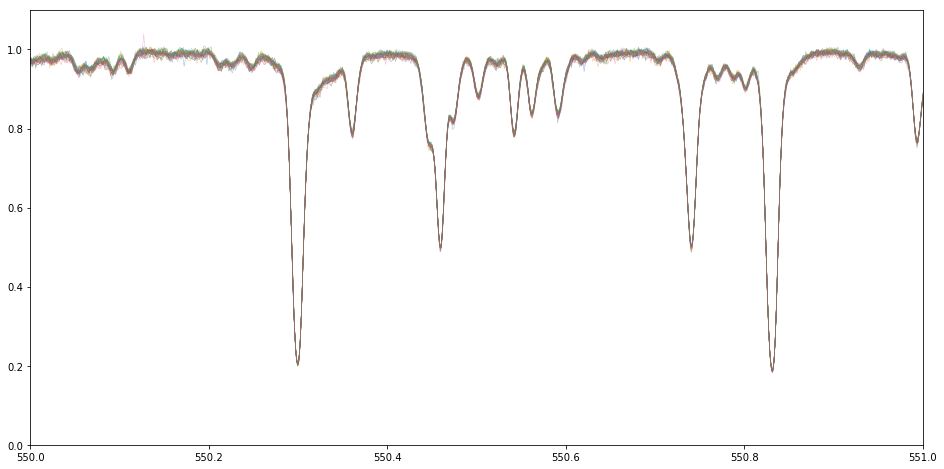

In [8]:
pl.figure(figsize=(16,8))
for i in np.arange(nfl):
    pl.plot(wav_corr[i,:],flux_norm[i,:],lw=0.5,alpha=0.5)
pl.xlim(550,551)
pl.ylim(0,1.1);

# ML fit

In [9]:
# Create 2-D array of scaled log wavelengths for fitting
K, N = wav.shape
lwav = np.log(wav * 1e-9) # in m
lw0, lw1 = lwav.min(), lwav.max()
x = (lwav - lw0) / (lw1 - lw0)

In [10]:
# First do GP fit to individual spectra to get estimate of GP HPs
print 'GP fit to individual spectra'
HPs = np.zeros((K,2))
for i in range(K):
    xx = wav_corr[i,:].flatten()
    yy = flux_norm[i,:].flatten()
    ee = err_norm[i,:].flatten()
    HPs[i,:] = u.Fit0(xx, yy, ee, verbose = False, xpred = None)
HPs = np.median(HPs, axis=0)
print 'Initial GP HPs:', HPs

GP fit to individual spectra


/Users/aigrain/anaconda/lib/python2.7/site-packages/autograd/core.py:69: RuntimeWarning: overflow encountered in exp
  result_value = self.fun(*argvals, **kwargs)
/Users/aigrain/.local/lib/python2.7/site-packages/celerite-0.3.0.dev0-py2.7-macosx-10.6-x86_64.egg/celerite/terms.py:566: RuntimeWarning: invalid value encountered in double_scalars
/Users/aigrain/anaconda/lib/python2.7/site-packages/autograd/core.py:69: RuntimeWarning: invalid value encountered in multiply
  result_value = self.fun(*argvals, **kwargs)
/Users/aigrain/anaconda/lib/python2.7/site-packages/autograd/core.py:69: RuntimeWarning: invalid value encountered in divide
  result_value = self.fun(*argvals, **kwargs)
/Users/aigrain/.local/lib/python2.7/site-packages/celerite-0.3.0.dev0-py2.7-macosx-10.6-x86_64.egg/celerite/terms.py:565: RuntimeWarning: overflow encountered in double_scalars
/Users/aigrain/anaconda/lib/python2.7/site-packages/autograd/core.py:69: RuntimeWarning: overflow encountered in true_divide
  result_

Initial GP HPs: [-1.68512596 -2.64558264]


In [11]:
from celerite import terms, GP
# Initial (ML) estimate of parameters
print "Starting ML fit"
par_in = np.zeros(K+1)
par_in[-2:] = HPs
ML_par = np.array(u.Fit1(wav_corr, flux_norm, err_norm, verbose = False, par_in = par_in))
par_ML = np.copy(ML_par)
par_ML[:K-1] *= (lw1 - lw0) * SPEED_OF_LIGHT * 1e-3
par_ML[-1] *= (lw1 - lw0)
print par_ML

Starting ML fit
[  6.62655805e-03   3.66066567e-03  -1.20681066e-02  -8.17891215e-03
  -1.16358108e-02   2.30134004e-02  -2.07288728e-03   7.61219985e-03
   8.93711691e-03  -7.00525074e-03  -1.02857305e-03   1.16499032e-02
  -6.11354978e-03  -7.06459296e-03  -1.17806267e-02  -3.86339031e-03
  -1.26670413e-02  -1.09272110e-02   7.82763431e-03  -1.36625523e-02
   1.56122115e-02  -1.91791763e-03  -6.27347765e-03  -9.61400602e-03
   1.01110276e-02  -2.77212601e-03   1.24441563e-02   1.65653761e-03
  -2.98025075e-03  -1.22720651e-02   3.29551066e-02   1.14066529e-02
   1.42339446e-02   1.20089419e-02  -1.68512566e+00  -2.95939172e-02]


In [12]:
k = terms.Matern32Term(log_sigma = ML_par[-2], log_rho = ML_par[-1])
gp = GP(k, mean = 1.0)
print "ML fit done"

ML fit done


# MCMC

In [ ]:
import emcee
import sys
nsteps = 250
ndim = K+1
nwalkers = ndim * 4
p0 = ML_par + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, u.LP1,
                                    args = [gp, wav_corr, flux_norm, err_norm])
for i, result in enumerate(sampler.sample(p0, iterations=nsteps)):
    n = int((30+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (30 - n)))
sys.stdout.write("\n")

[                              ]